In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from itertools import product
from sklearn.metrics import r2_score

In [3]:
fontsize = 14

# Loading the data

## Predicted $\hat \rho_i(t)$

We first load the predictions from the $x_i \,,\, N_i(t) \;\rightarrow\; \rho_i(t)$ regression :

In [4]:
predictions = np.load("predictions/level-1_position-Nt.npy")

We take the dimensionalities from this data :

In [5]:
n_plates, n_rows, n_columns, n_points = predictions.shape

In [6]:
plates, points = np.arange(n_plates), np.arange(n_points)

## $\rho_i(t)$

We then load the $\rho_i(t)$ from the data frame created in **level-1_calculations.ipynb** :

In [7]:
factors = pd.read_csv("factors/original-nt.csv")

In [8]:
rho = factors[
    [ f"rho({t})" for t in points ]
].values.reshape((n_plates, n_rows, n_columns, n_points))

## Train/Test data

We take from this data frame also the representation of the grid locations representing test data :

In [9]:
test = factors["test"].values.reshape((n_plates, n_rows, n_columns))

## Input importances

Finally, we load the importances of the various input features of our regression.
As the CSV file is in long format, we convert this data to wide format :

In [10]:
_ = pd.read_csv("importances/position-Nt.csv")
importances = _.pivot(values = "0", index = ["plate", "t"], columns = "factor")

Additionally, we combine the _row_ and _column_ importances into one _position_ importance :

In [11]:
importances["position"] = importances["column"] + importances["row"]
del importances["column"]
del importances["row"]

# Calculating the time-dependent $R^2$ scores

We use the `r2_scores` function to evaluate the regression model's performances, by calculating for every time point the $R^2$ :

In [12]:
train_scores = np.empty((n_plates, n_points))
test_scores = np.empty((n_plates, n_points))

for p, t in product(plates, points):
    train_scores[p, t] = r2_score(rho[p, test[p] == False, t], predictions[p, test[p] == False, t])
    test_scores[p, t] = r2_score(rho[p, test[p], t], predictions[p, test[p], t])

# Figure

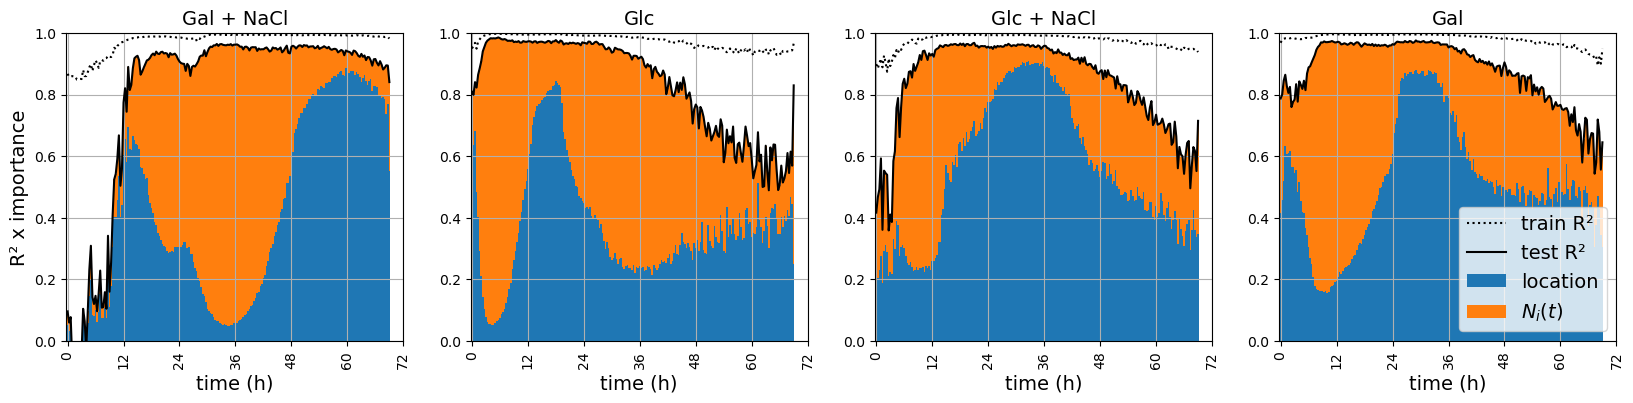

In [13]:
fig, axes = plt.subplots(ncols = n_plates, figsize = (20, 4))

envs = ["Gal + NaCl", "Glc", "Glc + NaCl", "Gal"]
for p, ax in enumerate(axes):
    ax.plot(train_scores[p], color = "black", linestyle = ":", label = "train R²")
    ax.plot(test_scores[p], color = "black", label = "test R²")
    
    (
        test_scores[p] * importances.loc[p, ["position", "N(t)"]].T
    ).T.plot.bar(
        stacked = True,
        width = 1,
        ax = ax,
        legend = False
    )
    
    ax.set_xlabel("time (h)", fontsize = fontsize)
    ax.set_xticks([0, 36, 72, 108, 144, 180, 216], labels = [0, 12, 24, 36, 48, 60, 72])
    ax.set_title(envs[p], fontsize = fontsize)
    ax.set_ylim(0, 1)
    ax.grid()
l = axes[3].legend(loc = "lower right",fontsize = fontsize)
l.get_texts()[2].set_text("location")
l.get_texts()[3].set_text(r"$N_i(t)$")
axes[0].set_ylabel("R² x importance", fontsize = fontsize)

fig.savefig("plots/figure-2/position-Nt.png", bbox_inches = "tight")
fig.savefig("plots/figure-2/position-Nt.pdf", bbox_inches = "tight")